Trong lab này, chúng ta sẽ triển khai 2 cơ chế Ensemble: simple linear mix và stacking.

Chúng ta sẽ dành vài cell để load dữ liệu và tạo ma trận đặc trưng, các bạn có thể kéo qua phần này hoặc tìm hiểu những gì đang diễn ra.

# Kiểm tra phiên bản

Điều đầu tiên cần làm là kiểm tra phiên bản thư viện.

In [1]:
import numpy as np
import pandas as pd 
import sklearn
import scipy.sparse 
import lightgbm 

for p in [np, pd, scipy, sklearn]:
    print (p.__name__, p.__version__)

C:\Users\Admin\miniconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Admin\miniconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
C:\Users\Admin\miniconda3\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


ModuleNotFoundError: No module named 'lightgbm'

**Quan trọng!** Rất có thể các bạn sẽ không đạt yêu câu của lab nếu phiên bản `lighgbm` và `scikit-learn` bị sai. Các phiên bản đang được thử nghiệm:

    numpy 1.18.5
    pandas 1.3.2
    scipy 1.4.1
    sklearn 0.23.2
    ligthgbm 3.2.1
    

Có thể sử dụng lệnh sau để cài phiên bản `lighgbm` cũ hơn: 
```
pip uninstall lightgbm
pip install lightgbm==3.2.1
```

# Ensembling

Tiếp theo, hãy import một số mô hình và phép đo, viết một hàm chuyển đổi cột từ định dạng '64 bit' thành '32 bit'. Điều này sẽ giúp tiết kiệm khá nhiều bộ nhớ.

In [ ]:
import pandas as pd
import numpy as np
import gc
import matplotlib.pyplot as plt
%matplotlib inline 

pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 50)

import lightgbm as lgb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from tqdm import tqdm_notebook

from itertools import product


def downcast_dtypes(df):
    '''
        Changes column types in the dataframe: 
                
                `float64` type to `float32`
                `int64`   type to `int32`
    '''
    
    ## Yêu cầu 1:
    ## VIẾT CODE Ở ĐÂY:

    # Chọn các cột để chuyển đổi
    float_cols = [c for c in df if df[...].dtype == "float64"]
    int_cols =   [c for c in df if df[...].dtype == "int64"]
    
    # Chuyển đổi
    df[float_cols] = df[...].astype(np.float32)
    df[...]   = df[int_cols].astype(np.int32)
    
    return df

# Load dữ liệu tập hợp con

Hãy load dữ liệu từ ổ cứng trước.

In [ ]:
sales = pd.read_csv('dataset/sales_train.csv.gz')
shops = pd.read_csv('dataset/shops.csv')
items = pd.read_csv('dataset/items.csv')
item_cats = pd.read_csv('dataset/item_categories.csv')

Và để đơn giản, chỉ sử dụng 3 shop.

In [ ]:
sales = sales[sales['shop_id'].isin([26, 27, 28])]

# Ma trận đặc trưng

Chúng ta cần chuẩn bị các đặc trưng, phần này đã được triển khai hoàn toàn cho bạn.

In [ ]:
# Tạo "grid" với các cột
index_cols = ['shop_id', 'item_id', 'date_block_num']

# Với mỗi month, chúng ta tạo một grid từ tất cả các tổ hợp shop/item từ month đó
grid = []

for block_num in sales['date_block_num'].unique():
    cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
    cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])),dtype='int32'))

# Biến grid thành một dataframe
grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)

## Yêu cầu 2:
## VIẾT CODE Ở ĐÂY:

# Nhóm dữ liệu để được tổ hợp shop-item-month
gb = sales.groupby(index_cols,as_index=False).agg({'item_cnt_day': 'sum'}).rename(columns={'item_cnt_day': 'target'})
# Nối nó vào grid
all_data = pd....(grid, gb, how='left', on=index_cols).fillna(0)

# Tương tự như trên nhưng với tổ hợp shop-month
gb = sales.groupby(['shop_id', 'date_block_num'],as_index=False).agg({'item_cnt_day': 'sum'}).rename(columns={'item_cnt_day': 'target_shop'})
all_data = pd....(all_data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)

# Tương tự như trên nhưng với tổ hợp item-month 
gb = sales.groupby(['item_id', 'date_block_num'],as_index=False).agg({'item_cnt_day': 'sum'}).rename(columns={'item_cnt_day': 'target_item'})
all_data = pd....(all_data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)

# Chuyển đổi dtypes từ 64 bit thành 32 bit để tiết kiệm bộ nhớ
all_data = downcast_dtypes(all_data)
del grid, gb 
gc.collect();

<details><summary> Gợi ý </summary>

[merge()](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.merge.html)

</details>

Sau khi tạo grid, chúng ta sẽ tính toán một số đặc trưng, sử dụng các lag từ [1, 2, 3, 4, 5, 12] tháng trước.

In [ ]:
# Danh sách các cột mà chúng ta sẽ sử dụng để tạo lag
cols_to_rename = list(all_data.columns.difference(index_cols)) 

shift_range = [1, 2, 3, 4, 5, 12]

for month_shift in tqdm_notebook(shift_range):
    train_shift = all_data[index_cols + cols_to_rename].copy()
    
    train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift
    
    foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
    train_shift = train_shift.rename(columns=foo)

    all_data = pd.merge(all_data, train_shift, on=index_cols, how='left').fillna(0)

del train_shift

# Không sử dụng dữ liệu cũ từ năm 2013
all_data = all_data[all_data['date_block_num'] >= 12] 

# Danh sách tất cả các đặc trưng được gắn cờ
fit_cols = [col for col in all_data.columns if col[-1] in [str(item) for item in shift_range]] 
# Chúng ta sẽ giảm chúng ở giai đoạn khớp
to_drop_cols = list(set(list(all_data.columns)) - (set(fit_cols)|set(index_cols))) + ['date_block_num'] 

# Hạng mục cho từng item
item_category_mapping = items[['item_id','item_category_id']].drop_duplicates()

all_data = pd.merge(all_data, item_category_mapping, how='left', on='item_id')
all_data = downcast_dtypes(all_data)
gc.collect();

C:\Users\ASUS\anaconda3\lib\site-packages\ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


Để đạt được điều này, chúng ta tạo một ma trận đặc trưng. Nó được lưu trữ trong biến `all_data`. Hãy xem:

In [ ]:
all_data.head(5)

,shop_id,item_id,date_block_num,target,target_shop,target_item,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,target_item_lag_2,target_shop_lag_2,target_lag_3,target_item_lag_3,target_shop_lag_3,target_lag_4,target_item_lag_4,target_shop_lag_4,target_lag_5,target_item_lag_5,target_shop_lag_5,target_lag_12,target_item_lag_12,target_shop_lag_12,item_category_id
0,28,10994,12,1.0,6949.0,1.0,0.0,1.0,8499.0,0.0,1.0,6454.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37
1,28,10992,12,3.0,6949.0,4.0,3.0,7.0,8499.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,7521.0,0.0,0.0,0.0,37
2,28,10991,12,1.0,6949.0,5.0,1.0,3.0,8499.0,0.0,0.0,0.0,0.0,1.0,5609.0,0.0,2.0,6753.0,2.0,4.0,7521.0,0.0,0.0,0.0,40
3,28,10988,12,1.0,6949.0,2.0,2.0,5.0,8499.0,4.0,5.0,6454.0,5.0,6.0,5609.0,0.0,2.0,6753.0,0.0,0.0,0.0,0.0,0.0,0.0,40
4,28,11002,12,1.0,6949.0,1.0,0.0,1.0,8499.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40


# Phân tách tập huấn luyện/kiểm tra

Với lab này, hay phân chia dữ liệu thành tập huán luyện và tập kiểm tra. Chúng ta sẽ coi dữ liệu tháng trước là tập kiểm tra còn các tháng còn lại là tập huấn luyện.

In [ ]:
# Lưu `date_block_num`, vì chúng ta không thể sử dụng chúng làm đặc trưng, nhưng cần chúng để phân chia tập dữ liệu thành các phần
dates = all_data['date_block_num']

last_block = dates.max()
print('Test `date_block_num` is %d' % last_block)

Test `date_block_num` is 33


In [ ]:
## Yêu cầu 3:
## VIẾT CODE Ở ĐÂY:

dates_train = dates[dates <  ...]
dates_test  = dates[dates == ...]

X_train = all_data.loc[dates <  ...].drop(to_drop_cols, axis=1)
X_test =  all_data.loc[dates == ...].drop(to_drop_cols, axis=1)

y_train = all_data.loc[dates <  ..., 'target'].values
y_test =  all_data.loc[dates == ..., 'target'].values

<details><summary> Gợi ý </summary>

Sử dụng ```last_block```

</details>

# Mô hình first level  

Chúng ta cần triển khai một cơ chế stacking cơ bản. Chúng ta có thành phần thời gian nên chúng ta sẽ dùng ***scheme f)*** từ tài liệu đọc. Chúng ta luôn sử dụng mô hình first level (tầng thứ nhất) để xây dựng 2 tập dữ liệu: test meta-features và train-metafeatures tầng 2. Trước tiên hãy xem cách lấy test meta-features.

### Test meta-features

Đầu tiên, chúng ta chạy *hồi quy tuyến tính* trong các cột số và lấy dự đoán cho tháng trước.

In [ ]:
lr = LinearRegression()
lr.fit(X_train.values, y_train)
pred_lr = lr.predict(X_test.values)

print('Test R-squared for linreg is %f' % r2_score(y_test, pred_lr))

Test R-squared for linreg is 0.743180


Sau đó, chúng ta chạy *LightGBM*.

In [ ]:
lgb_params = {
               'feature_fraction': 0.75,
               'metric': 'rmse',
               'nthread':1, 
               'min_data_in_leaf': 2**7, 
               'bagging_fraction': 0.75, 
               'learning_rate': 0.03, 
               'objective': 'mse', 
               'bagging_seed': 2**7, 
               'num_leaves': 2**7,
               'bagging_freq':1,
               'verbose':0 
              }

model = lgb.train(lgb_params, lgb.Dataset(X_train, label=y_train), 100)
pred_lgb = model.predict(X_test)

print('Test R-squared for LightGBM is %f' % r2_score(y_test, pred_lgb))

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019552 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Test R-squared for LightGBM is 0.731249


Cuối cùng, nối các dự đoán kiểm tra để thu được test meta-features.

In [ ]:
X_test_level2 = np.c_[pred_lr, pred_lgb] 

### Train meta-features

**Giờ đến lượt bạn viết code**. Chúng ta sẽ triển khai ***scheme f)*** từ tài liệu đọc. Ở đây, chúng ta sẽ sử dụng khoảng **T** tương đương với một tháng và **M=15**.

Các bạn cần thu được dự đoán (meta-features) từ *hồi quy tuyến tính* và *LightGBM* cho các tháng 27, 28, 29, 30, 31, 32. Dùng các tham số tương tự như ở mô hình trên.

In [ ]:
dates_train_level2 = dates_train[dates_train.isin([27, 28, 29, 30, 31, 32])]

# Đây là cách chúng ta lấy được target cho tập dữ liệu tầng thứ 2
y_train_level2 = y_train[dates_train.isin([27, 28, 29, 30, 31, 32])]

In [ ]:
# Ở đây, chúng ta tạo ma trận đặc trưng tầng thứ 2, khởi tạo nó với các số 0
X_train_level2 = np.zeros([y_train_level2.shape[0], 2])

# Giờ hãy điền metafeatures vào `X_train_level2`
for cur_block_num in [27, 28, 29, 30, 31, 32]:
    
    print(cur_block_num)
    
    '''
        1. Chia `X_train` thành các phần
           Nhớ rằng ngày tháng tương ứng được lưu trữ trong `dates_train`
        2. Khớp hồi quy tuyến tính
        3. Khớp LightGBM và đặt các dự đoán      
        4. Lưu trữ dự đoán từ 2. và 3. đúng chỗ trong `X_train_level2`. 
           Bạn có thể sử dụng `dates_train_level2` cho nó
           Đảm bảo thứ tự của meta-features tương tự như trong `X_test_level2`
    ''' 

    ## Yêu cầu 4:
    ## VIẾT CODE Ở ĐÂY:     
    
    X_train = all_data.loc[dates <  ...].drop(to_drop_cols, axis=1)
    X_test =  all_data.loc[dates == ...].drop(to_drop_cols, axis=1)

    y_train = all_data.loc[dates <  ..., 'target'].values
    
    
    lr.fit(X_train.values, y_train)
    pred_lr = lr.predict(X_test.values)
    model = lgb.train(lgb_params, lgb.Dataset(X_train, label=y_train), 100)
    pred_lgb = model.predict(X_test)
    
    indexes = dates_train_level2.index[dates_train_level2 == ...]
    
    for i in range(pred_lgb.shape[0]):
        X_train_level2[indexes[i] - 120192] = [pred_lr[i], pred_lgb[i]] 

27
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013825 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
28
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.016036 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
29
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.019783 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
30
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015675 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
31
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the over

<details><summary> Gợi ý </summary>

Sử dụng ```cur_block_num```

</details>

Ensemble hoạt động tốt nhất khi các mô hình tầng thứ nhất khác nhau. Chúng ta có thể phân tích định tính độ đa dạng bằng cách kiểm tra *biểu đồ phân tán* giữa 2 metafeatures. Biểu đồ phân tán bên dưới:

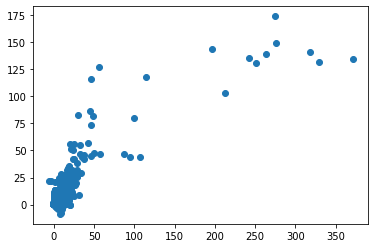

In [ ]:
import matplotlib.pyplot as plt

x = X_train_level2[:,0]
y = X_train_level2[:,1]
plt.scatter(x, y)
plt.show()

# Ensembling

Meta-features đã được tạo, giờ đây chúng ta có thể lắp ráp mô hình first level. 

### Simple convex mix

Hãy bắt đầu với hỗn hợp lồi tuyến tính (linear convex mix) đơn giản:

$$
mix= \alpha\cdot\text{linreg_prediction}+(1-\alpha)\cdot\text{lgb_prediction}
$$

Chúng ta cần tìm một $\alpha$ tối ưu. Điều này rất dễ, do tìm kiếm grid khá khả thi. Tiếp theo, hãy tìm $\alpha$ tối ưu trong mảng `alphas_to_try`. Nhớ sử dụng train meta-features khi tìm $\alpha$.

In [ ]:
alphas_to_try = np.linspace(0, 1, 1001)

best_alpha = -1
r2_train_simple_mix = -1

## Yêu cầu 5:
## VIẾT CODE Ở ĐÂY:

for current_alpha in alphas_to_try:
    mix = ... * ...[:,0] + (1 - ...) * ...[:,1]
    current_r2 = r2_score(y_train_level2, mix)
    if(current_r2 > ...):
        r2_train_simple_mix = ...
        best_alpha = ...

print('Best alpha: %f; Corresponding r2 score on train: %f' % (best_alpha, r2_train_simple_mix))

Best alpha: 0.762000; Corresponding r2 score on train: 0.627196


Giờ hãy sử dụng $\alpha$ đã tìm thấy để tính toán các dự đoán cho tập kiểm tra.

In [ ]:
## Yêu cầu 6:
## VIẾT CODE Ở ĐÂY:

test_preds = ... * ...[:,0] + (1 - ...) * ...[:,1]
r2_test_simple_mix = r2_score(y_test, test_preds)

print('Test R-squared for simple mix is %f' % r2_test_simple_mix)

Test R-squared for simple mix is 0.781210


### Stacking

Bây giờ, chúng ta sẽ thử một kỹ thuật ensembling nâng cao hơn. Hãy khớp mô hình hồi quy tuyến tính với meta-features, sử dụng các tham số tương tự như với mô hình ở trên. 

In [ ]:
lr.fit(X_train_level2, y_train_level2)

LinearRegression()

Tính R-squared tròn các tập huấn luyện và kiểm tra.

In [ ]:
## Yêu cầu 7:
## VIẾT CODE Ở ĐÂY:

train_preds = lr.predict(...)
r2_train_stacking = r2_score(y_train_level2, ...)

test_preds = lr.predict(...)
r2_test_stacking = r2_score(y_test, ...)

print('Train R-squared for stacking is %f' % r2_train_stacking)
print('Test  R-squared for stacking is %f' % r2_test_stacking)

Train R-squared for stacking is 0.632092
Test  R-squared for stacking is 0.771342


Điều thú vị là hệ số ở đây hóa ra lại thấp hơn so với phương pháp trước. Mặc dù mô hình rất đơn giản (chỉ có 3 tham số) và thực tế nó kết hợp các dự đoán môt cách tuyến tính, nhưng có vẻ như nó bị overfit. **Hãy kiểm tra và so sánh** các hệ số huấn luyện và kiểm tra cho 2 phương pháp này.

Tất nhiên, trường hợp này không có nghĩa là simple mix luôn tốt hơn stacking.

In [ ]:
print('Current answer for task best_alpha is:',best_alpha)
print('Current answer for task r2_train_simple_mix is:',r2_train_simple_mix)
print('Current answer for task r2_test_simple_mix is:',r2_test_simple_mix)
print('Current answer for task r2_train_stacking is:',r2_train_stacking)
print('Current answer for task r2_test_stacking is',r2_test_stacking)

Current answer for task best_alpha is: 0.762
Current answer for task r2_train_simple_mix is: 0.6271958302095337
Current answer for task r2_test_simple_mix is: 0.78121029643639
Current answer for task r2_train_stacking is: 0.632092200807367
Current answer for task r2_test_stacking is 0.7713418067296549
